In [ ]:
import numpy as np
import pandas as pd
import requests
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM, Dense,Dropout, GRU, Input,LayerNormalization, MultiHeadAttention,Flatten,Conv1D,MaxPooling1D,Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


fapi=f"https://financialmodelingprep.com/api/v3/key-metrics/AAPL?limit=1&apikey=6jOSYrWTaOpAwmkxYBIwAHQoSszIUx4G"
papi=f"https://financialmodelingprep.com/stable/historical-price-eod/full?symbol=AAPL&apikey=6jOSYrWTaOpAwmkxYBIwAHQoSszIUx4G"
fundamental=requests.get(fapi).json()
price=requests.get(papi).json()


df=pd.DataFrame(price)

df['50ma']=df['close'].rolling(50).mean()
df['200ma']=df['close'].rolling(200).mean()

window = 14
delta = df["close"].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window).mean()
avg_loss = loss.rolling(window).mean()

rs = avg_gain / avg_loss
df["RSI"] = 100 - (100 / (1 + rs))

ema_12 = df["close"].ewm(span=12, adjust=False).mean()
ema_26 = df["close"].ewm(span=26, adjust=False).mean()

df["MACD"] = ema_12 - ema_26
df["Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()
df["MACD_Histogram"] = df["MACD"] - df["Signal"]

bb_window = 20
df["BB_Middle"] = df["close"].rolling(bb_window).mean()
df["BB_STD"] = df["close"].rolling(bb_window).std()

df["BB_Upper"] = df["BB_Middle"] + (2 * df["BB_STD"])
df["BB_Lower"] = df["BB_Middle"] - (2 * df["BB_STD"])

df["volume_ma_20"] = df["volume"].rolling(20).mean()
df["volume_spike"] = df["volume"] > 1.5 * df["volume_ma_20"]

df['golden_cross']=(df['50ma']>df['200ma'])&(df['50ma'].shift(1)<=df['200ma'].shift(1))
df['death_cross']=(df['50ma']<df['200ma'])&(df['50ma'].shift(1)>=df['200ma'].shift(1))

seq_features = ['open', 'high', 'low', 'close', 'volume']
indicator_features = [
    'RSI', 'MACD', 'Signal', 'MACD_Histogram',
    'BB_Middle', 'BB_Upper', 'BB_Lower',
    'volume_ma_20', 'golden_cross', 'death_cross'
]
target_column = 'close'  # or 'changePercent' or 'next_day_return'

sequence_length = 20

X_seq, X_ind, y = [], [], []

# Convert boolean to int if needed
df['golden_cross'] = df['golden_cross'].astype(int)
df['death_cross'] = df['death_cross'].astype(int)

for i in range(sequence_length, len(df)):
    seq_data = df[seq_features].iloc[i-sequence_length:i].values
    ind_data = df[indicator_features].iloc[i].values
    target = df[target_column].iloc[i]

    # Skip rows with NaN
    if np.isnan(seq_data).any() or np.isnan(ind_data).any() or pd.isna(target):
        continue

    X_seq.append(seq_data)
    X_ind.append(ind_data)
    y.append(target)

# Convert to arrays
X_seq = np.array(X_seq)[::-1]      # Shape: (N, 20, 5)
X_ind = np.array(X_ind)[::-1]      # Shape: (N, 10)
y = np.array(y)[::-1] # Shape: (N,)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-6)
]

seq_input=Input(shape=(20,5))
x1=Conv1D(filters=32,kernel_size=3,activation='relu')(seq_input)
x1=MaxPooling1D(pool_size=2)(x1)
x1=LSTM(64)(x1)
x1=Dense(64,activation='relu')(x1)

ind_input=Input(shape=(10,))
y1=Dense(32,activation='relu')(ind_input)
y1=Dense(32,activation='relu')(y1)

combined=Concatenate()([x1,y1])
z1=Dense(64,activation='relu')(combined)
z1=Dropout(0.3)(z1)
z1=Dense(1,activation='linear')(z1)

model=Model(inputs=[seq_input,ind_input],outputs=z1)
model.compile(optimizer=Adam(learning_rate=0.001),loss='mse')

model.fit(
    [X_seq,X_ind],y,
    validation_split=0.2,
    epochs=30,
    batch_size=32
)

y_pred=model.predict([X_seq,X_ind])
y_pred-y

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 6447445311488.0000 - val_loss: 891799040.0000
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 896162267136.0000 - val_loss: 10467843072.0000
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 201247817728.0000 - val_loss: 5600902144.0000
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 85976752128.0000 - val_loss: 1842456704.0000
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 23481733120.0000 - val_loss: 26900980.0000
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8773286912.0000 - val_loss: 227717.4375
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4365079552.0000 - val_loss: 1088426.2500
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2996622848.0000 - val_loss: 23948546.0000
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1916392576.0000 - val_loss: 3747725.7500
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1296480768.0000 - 

array([[1035.56842285, 1025.49842285, 1022.81842285, ...,  930.75842285,
         930.67842285,  926.58842285],
       [1035.02936035, 1024.95936035, 1022.27936035, ...,  930.21936035,
         930.13936035,  926.04936035],
       [ 982.5879541 ,  972.5179541 ,  969.8379541 , ...,  877.7779541 ,
         877.6979541 ,  873.6079541 ],
       ...,
       [ 199.53738647,  189.46738647,  186.78738647, ...,   94.72738647,
          94.64738647,   90.55738647],
       [ 196.42532593,  186.35532593,  183.67532593, ...,   91.61532593,
          91.53532593,   87.44532593],
       [ 186.51150757,  176.44150757,  173.76150757, ...,   81.70150757,
          81.62150757,   77.53150757]])

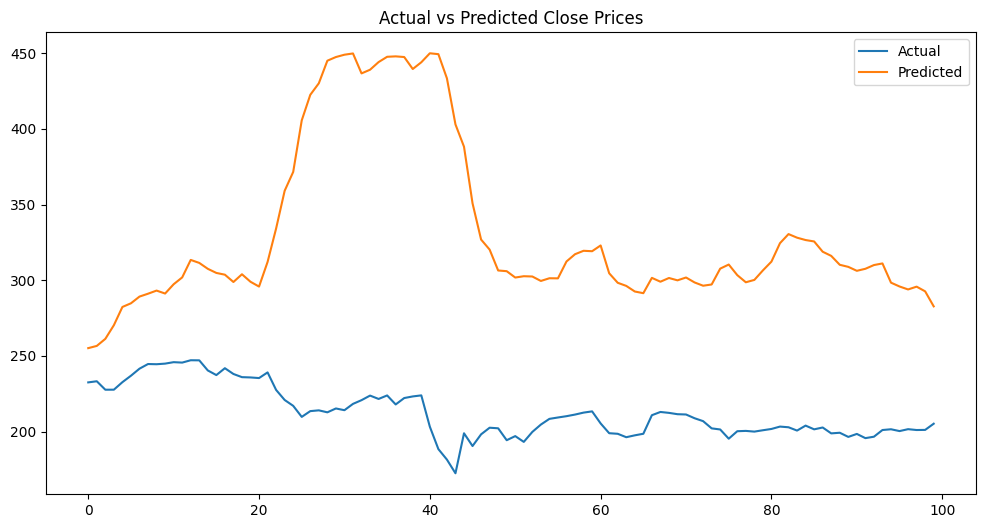

,symbol,date,open,high,low,close,volume,change,changePercent,vwap,...,Signal,MACD_Histogram,BB_Middle,BB_STD,BB_Upper,BB_Lower,volume_ma_20,volume_spike,golden_cross,death_cross
0,AAPL,2025-07-29,214.175,214.41,214.175,214.395,1655660,0.2200,0.102720,214.3300,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,False,0,0
1,AAPL,2025-07-28,214.030,214.85,213.060,214.050,37858017,0.0200,0.009344,213.9975,...,-0.005504,-0.022017,NaN,NaN,NaN,NaN,NaN,False,0,0
2,AAPL,2025-07-25,214.700,215.24,213.400,213.880,40268800,-0.8200,-0.381930,214.3050,...,-0.016870,-0.045462,NaN,NaN,NaN,NaN,NaN,False,0,0
3,AAPL,2025-07-24,213.900,215.69,213.530,213.760,46022620,-0.1400,-0.065451,214.2200,...,-0.033189,-0.065277,NaN,NaN,NaN,NaN,NaN,False,0,0
4,AAPL,2025-07-23,215.000,215.15,212.410,214.150,46989301,-0.8500,-0.395350,214.1775,...,-0.045460,-0.049084,NaN,NaN,NaN,NaN,NaN,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,AAPL,2020-08-05,109.380,110.39,108.900,110.060,121991952,0.6850,0.621690,109.6825,...,-0.953162,-1.082233,118.9445,7.176364,133.297229,104.591771,187093548.1,False,0,0
1251,AAPL,2020-08-04,109.130,110.79,108.390,109.670,173071600,0.5325,0.494820,109.4950,...,-1.211481,-1.033273,117.7190,6.498432,130.715864,104.722136,188123621.0,False,0,0
1252,AAPL,2020-08-03,108.200,111.64,107.890,108.940,308151388,0.7375,0.683920,109.1675,...,-1.457471,-0.983962,116.7140,6.203005,129.120009,104.307991,192246055.4,True,0,0
1253,AAPL,2020-07-31,102.880,106.42,100.830,106.260,374336800,3.3800,3.290000,104.0975,...,-1.722276,-1.059218,115.7865,6.314577,128.415655,103.157345,201581395.4,True,0,0


In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y[-100:], label='Actual')
plt.plot(y_pred[-100:], label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Close Prices')
plt.show()
df

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.5337 - val_loss: 0.0348
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0787 - val_loss: 0.0170
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0499 - val_loss: 0.0134
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0357 - val_loss: 0.0111
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0429 - val_loss: 0.0085
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0305 - val_loss: 0.0138
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0388 - val_loss: 0.0100
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0296 - val_loss: 0.0069
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0300 - val_loss: 0.0092
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0284 - val_loss: 0.0100
Epoch 11/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0292 - val_loss: 0.0070
Epoch 12/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

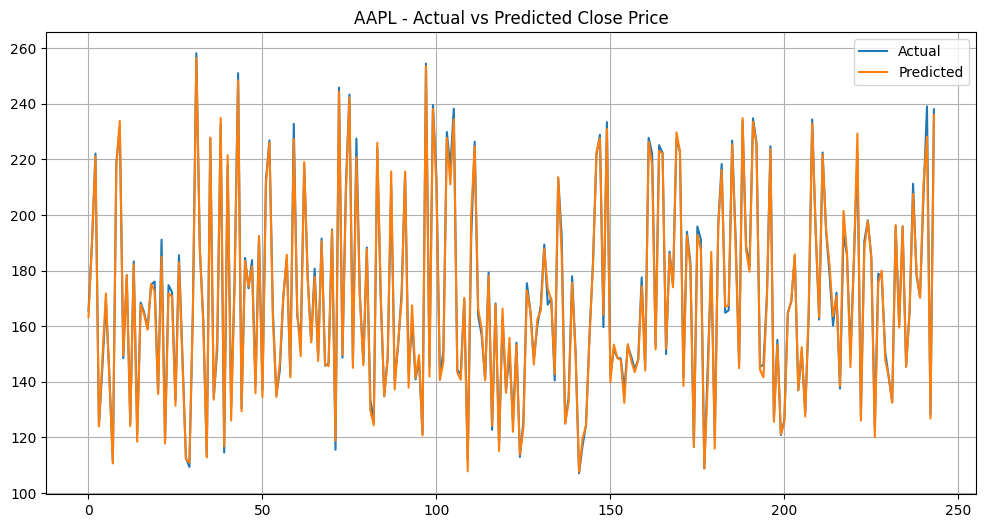

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
# ---- Train/Test Split ----
from sklearn.preprocessing import StandardScaler

# ---- Feature Definitions ----
seq_features = ['open', 'high', 'low', 'close', 'volume']
indicator_features = [
    'RSI', 'MACD', 'Signal', 'MACD_Histogram',
    'BB_Middle', 'BB_Upper', 'BB_Lower',
    'volume_ma_20', 'golden_cross', 'death_cross'
]
target_column = 'close'
sequence_length = 20

# ---- Preprocessing ----
# Convert boolean to int
df['golden_cross'] = df['golden_cross'].astype(int)
df['death_cross'] = df['death_cross'].astype(int)

# Drop rows with missing values
df.dropna(subset=seq_features + indicator_features + [target_column], inplace=True)

X_seq, X_ind, y = [], [], []

for i in range(sequence_length, len(df)):
    seq_data = df[seq_features].iloc[i-sequence_length:i].values
    ind_data = df[indicator_features].iloc[i].values
    target = df[target_column].iloc[i]

    if np.isnan(seq_data).any() or np.isnan(ind_data).any() or pd.isna(target):
        continue

    X_seq.append(seq_data)
    X_ind.append(ind_data)
    y.append(target)

# Convert to arrays
X_seq = np.array(X_seq)
X_ind = np.array(X_ind)
y = np.array(y)


callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-6)
]

scaler_seq = StandardScaler()
scaler_ind = StandardScaler()
scaler_y = StandardScaler()

X_seq_flat = X_seq.reshape(-1, len(seq_features))  # Flatten time dimension
X_seq_scaled = scaler_seq.fit_transform(X_seq_flat).reshape(X_seq.shape)

X_ind_scaled = scaler_ind.fit_transform(X_ind)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Train-test split
X_seq_train, X_seq_val, X_ind_train, X_ind_val, y_train, y_val = train_test_split(
    X_seq_scaled, X_ind_scaled, y_scaled, test_size=0.2, random_state=42
)

# ---- Model Definition ----
seq_input = Input(shape=(sequence_length, len(seq_features)))
x = Conv1D(filters=32, kernel_size=3, activation='relu')(seq_input)
x = MaxPooling1D(pool_size=2)(x)
attn = MultiHeadAttention(num_heads=4, key_dim=32)(seq_input, seq_input)
attn = Add()([attn, seq_input])
attn = LayerNormalization()(attn)
x = LSTM(64)(x)
x = Dense(64, activation='relu')(x)

ind_input = Input(shape=(len(indicator_features),))
y1 = Dense(32, activation='relu')(ind_input)
y1 = Dense(32, activation='relu')(y1)

combined = Concatenate()([x, y1])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1, activation='linear')(z)

model = Model(inputs=[seq_input, ind_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# ---- Model Training ----
model.fit(
    [X_seq_train, X_ind_train], y_train,
    validation_data=([X_seq_val, X_ind_val], y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)

# ---- Predictions & Evaluation ----
y_pred_scaled = model.predict([X_seq_val, X_ind_val]).reshape(-1)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# ---- Plot Actual vs Predicted ----
plt.figure(figsize=(12, 6))
plt.plot(y_val, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("AAPL - Actual vs Predicted Close Price")
plt.legend()
plt.grid(True)
plt.show()


In [38]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 20, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 18, 32)    │        512 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 9, 32)     │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 64)        │     24,832 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 32)        │        352 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │      4,160 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 32)        │      1,056 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 96)        │          0 │ dense_25[0][0],   │
│ (Concatenate)       │                   │            │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │      6,208 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 111,557 (435.77 KB)

 Trainable params: 37,185 (145.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 74,372 (290.52 KB)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 100) + inhomogeneous part.

ValueError: <class 'function'> is not currently a supported model type!